# Applied Data Science Capstone by
###### Submission to IBM Data Science Captsone project module 9 by Dave CK
# Locating areas for a new venue in an unknown city

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

Investors frequently need to make judgements about an opportunity in an area that they are not familiar with. Local regulations, cultural norms, and geographic idiosyncrasies make it difficult to know the layout of a foreign city's busy spots without spending significant time there. 

Investors would benefit from knowing the distribution of foot traffic at certain times of day so as to avoid situations like:
- investing in a nightclub on a street filled mostly with daytime stores
- investing in a hardware store in the middle of the clubbing district
- opening any venue without being aware of the layout of the city (eg. steep hills causing venues to cluster at the bottom)

Given a set of intended opening hours and a general location (eg. a city's coordinates), the goal of this notebook is to suggest areas of a city that would experience good foot traffic during those hours. It could be of use not only to investors but to anyone (eg city service planners) needing to know when and where the city is quiet/busy.

# Data <a name="data"></a>
The data needed to produce the suggestion can be queried from Foursquare's API, but careful consideration must be made to work within the limits of the API's free service, which limits the number of queries that can be made, as well as the number of results each query returns.

Each query can return 30 venues.
- **Gather the data:**
- - Select the centre of an area and create a grid of lat/long coordinates around it.
- - Query the API for each of the lat/long coordinates in the array.
- - Combine the data from each API query. The points will be close enough to cause overlap (ensuring coverage), and duplicates will be removed.
- - Query the API for each venue and extract the opening hours

In [1]:
import pandas as pd
import numpy as np
import requests as r
from pandas.io.json import json_normalize
import json
import folium
import math
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Select area of interest

In [2]:
area_centre = (53.480472, -2.246467)

# Search a grid around that area

In [3]:
CLIENT_ID = 'PEBSOVVA0A5224DCOVK03YIXHRGKENPFXT25GPAOOI0EAUN4' 
CLIENT_SECRET = 'UTLG4CJXMANFCDEJOVCWJ5SDLSEQK2LS1R234RLOUXRFABT2'
VERSION = '20180604'
radius = 200
intent = 'browse'
folium_colours = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
             'lightred', 'darkblue', 'cadetblue',
             'darkpurple', 'pink', 'lightblue', 'lightgreen',
             'gray', 'black', 'lightgray']

In [4]:
lat, long = area_centre[0], area_centre[1]
URI = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}'.format(CLIENT_ID, 
                                                                                                                           CLIENT_SECRET, 
                                                                                                                           VERSION, 
                                                                                                                           lat, long, 
                                                                                                                           intent, 
                                                                                                                           radius)
call = r.get(URI)

In [5]:
replydf = json_normalize(call.json()['response']['venues'])
replydf.head()
# here is a sample of the responses from Foursquare

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
1  [{'id': '4bf58dd8d48988d174941735', 'name': 'C...    False   
2  [{'id': '52e81612bcbc57f1066b7a05', 'name': 'E...    False   
3  [{'id': '4bf58dd8d48988d10b941735', 'name': 'F...    False   
4  [{'id': '4bf58dd8d48988d124941735', 'name': 'O...    False   

                         id     location.address location.cc location.city  \
0  4ade0dddf964a5207f6d21e3    28 John Dalton St          GB    Manchester   
1  5d00eb804940bc002c4f646d                  NaN          GB           NaN   
2  53ba84fb498e3b8ad1ff0855  8-12 John Dalton St          GB    Manchester   
3  581a1fed12d23675fd5ae6a0         99 Denesgate          GB    Manchester   
4  4be80c53947820a18562b4db     St. James Square          GB    Manchester   

  location.country location.crossStreet  location.distance  \
0   United Kingdom                  NaN                 14   
1   United Kingdom                  NaN                 13   
2   United Kingdom                  NaN                 61   
3   United Kingdom                  NaN                110   
4   United Kingdom                  NaN                 22   

                           location.formattedAddress  \
0  [28 John Dalton St, Manchester, M2 6HQ, United...   
1                           [M2 6DS, United Kingdom]   
2  [8-12 John Dalton St, Manchester, Greater Manc...   
3  [99 Denesgate, Manchester, Greater Manchester,...   
4     [St. James Square, Manchester, United Kingdom]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.48048496208448...     53.480485   
1  [{'label': 'display', 'lat': 53.48056, 'lng': ...     53.480560   
2  [{'label': 'display', 'lat': 53.48065056130512...     53.480651   
3  [{'label': 'display', 'lat': 53.481224, 'lng':...     53.481224   
4  [{'label': 'display', 'lat': 53.48046272071359...     53.480463   

   location.lng location.neighborhood location.postalCode      location.state  \
0     -2.246252                   NaN              M2 6HQ                 NaN   
1     -2.246327                   NaN              M2 6DS                 NaN   
2     -2.247343                   NaN              M2 6JP  Greater Manchester   
3     -2.247549                   NaN              M3 2BQ  Greater Manchester   
4     -2.246129                   NaN                 NaN                 NaN   

                  name    referralId  
0      The Ape & Apple  v-1565191080  
1  Wework Dalton Place  v-1565191080  
2    Bill's Restaurant  v-1565191080  
3           Go Falafel  v-1565191080  
4             KPMG LLP  v-1565191080

Let's look at how widely the returned results are spread. Our grid will need to be dense enough to ensure that we retrieve all the venues within it.

In [6]:
venues_map = folium.Map(location=[area_centre[0], area_centre[1]], zoom_start = 15) # generate map centred on the mean lat/long of our selection

for lat, lng in zip(replydf['location.lat'], replydf['location.lng']): #, label , filtered_df['name']
        folium.features.CircleMarker(
                                    [lat, lng],
                                    radius = 15,
                                    color = 'red',
                                 #   popup = label,
                                    fill = True,
                                    fill_color = 'red',
                                    fill_opacity = 0.2
                                    ).add_to(venues_map)

# display map
print("Venues returned from one API call")
venues_map

Venues returned from one API call


In [7]:
#create grid of points around the area's centre

degree = 5000
x = area_centre[0]
min_x = x - x / degree
max_x = x + x / degree

y = area_centre[1]
min_y = y - y / (degree/40)
max_y = y + y / (degree/40)

steps = int(round(math.sqrt(300),0)) #API limits to 500 calls in an hour, so create as many points as we can safely call in one go
x_range = np.linspace(min_x, max_x, steps)
y_range = np.linspace(min_y, max_y, steps)

grid = []

for lat in x_range:
    for long in y_range:
        grid.append((lat, long))


In [8]:
#view the points 
grid_map = folium.Map(location=[x, y], zoom_start = 15) # generate map centred on the mean lat/long of our selection

for lat, long in grid:
        folium.features.CircleMarker(
                                    [lat, long],
                                    radius = 3,
                                    color = 'green',
                                 #   popup = label,
                                    fill = True,
                                    fill_color = 'green',
                                    fill_opacity = 0.6
                                    ).add_to(grid_map)

for lat, lng in zip(replydf['location.lat'], replydf['location.lng']): #, label , filtered_df['name']
        folium.features.CircleMarker(
                                    [lat, lng],
                                    radius = 15,
                                    color = 'red',
                                 #   popup = label,
                                    fill = True,
                                    fill_color = 'red',
                                    fill_opacity = 0.6
                                    ).add_to(grid_map)

        
# display map
print('In green: grid composed of', len(grid), 'points around the central coordinates')
print('In red: the venues returned by a single API call')
print("Significant overlap is promising as it will help to return all venues regardless of the 30 limit set by Foursquare's API")
grid_map


In green: grid composed of 289 points around the central coordinates
In red: the venues returned by a single API call
Significant overlap is promising as it will help to return all venues regardless of the 30 limit set by Foursquare's API


The grid (in green) is suitably dense: the venues from a single call to Foursquare (red circles) sit atop several grid points, meaning that we will get plenty of overlap in our results, and can be fairly confident that we have picked up every venue in the area. This step is not perfect. An ideal solution would involve a paid Foursquare account so that better results can be returned.

In [9]:
# query the Foursquare API for venues around each point in the grid

venues_pickle_title = 'all_venues'

# check if we have an existing pickle of the venues dataframe

try: #if it exists, load it
    venues_df = pickle.load(open(venues_pickle_title, "rb" ))
    print('Found existing venues dataframe and loaded that pickle')
    print('To start a new search, delete the pickle first')
    print(venues_df.shape[0], 'rows in pickle')
    
except: #it not, create a new dataframe
    print('There are no saved venues, creating new dataframe')
    venues_df = pd.DataFrame(columns = list(replydf.columns).append('point_number'))
    for index, point in enumerate(grid):
        lat = point[0]
        long = point[1]
        URI = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&intent={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, intent, radius)
        call = r.get(URI)
        point_df = json_normalize(call.json()['response']['venues'])
        point_df['point_number'] = index #add a marker in case we want to assess the degree of overlap
        venues_df = venues_df.append(point_df, ignore_index = True)
        print("Point {} complete with {} rows added".format(index, point_df.shape[0]))
        
    #save the venues to pickle
    pickle.dump(venues_df, open(venues_pickle_title, "wb"))


Found existing venues dataframe and loaded that pickle
To start a new search, delete the pickle first
11457 rows in pickle


We have a significant number of venues in the intentionally overlapping catchment area. Let's clean out the duplicates to get the essential list of venues on the grid.

In [10]:
venues_df.drop_duplicates(subset = "id", inplace = True) 
venues_df.shape

(3354, 22)

We have whittled that down to 3354 venues, which is more realistic but still quite high. The number of duplicates is an assurance that our grid was not too sparse.

### Extract categories
Categories are nested dictionaries:

In [11]:
venues_df.loc[0, 'categories']

[{'id': '4bf58dd8d48988d138941735',
  'name': 'Mosque',
  'pluralName': 'Mosques',
  'shortName': 'Mosque',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/religious_mosque_',
   'suffix': '.png'},
  'primary': True}]

We will extract the interesting part with a function

In [12]:
def extract_category(cell):
    try:
        result = cell[0]['name']
    except:
        result = "None"
    return result

venues_df['categories_simplified'] = venues_df.categories.apply(extract_category)

We will also remove several unwanted categories so as to reduce the number of API calls. Ideally this step would not be performed, but it is pragmatic to do so for the context of this coursework.

In [13]:
unwanted_categories = ['Residential Building (Apartment / Condo)',
                      'Office',
                      'None',
                      'Building',
                      'Platform',
                      'Bus Stop',
                      'University',
                      'College Academic Building',
                      'Bus Line',
                      'Housing Development',
                      'Rental Car Location',
                      'College Residence Hall',
                      'Coworking Space',
                      'Train Station',
                      'Light Rail Station',
                      'Tram Station',
                      'Train',
                      'Bridge',
                      'General College & University',
                      'Construction & Landscaping',
                      'Tech Startup',
                      'Government Building',
                      'Gas Station',
                      'Cemetery',
                      'Auto Garage',
                      'Corporate Amenity',
                      'Parking',
                      'Gym',
                      'Park',
                      'Church',
                      'Bank',
                      'Synagogue',
                      'Shrine',
                      'Prison',
                      'Hospital',
                      'Gym / Fitness Center',
                      'Paper / Office Supplies Store',
                      'Campaign Office',
                      'Voting Booth']

In [14]:
venues_df = venues_df[~venues_df['categories_simplified'].isin(unwanted_categories)]

In [15]:
venues_df.shape

(2226, 23)

We now have fewer than 3000 venues. We can call the API on 5 separate days to retrieve opening hours for all of them.

In [16]:
venues_map = folium.Map(location=[area_centre[0], area_centre[1]], zoom_start = 14) # generate map centred on the mean lat/long of our selection

for lat, lng in zip(venues_df['location.lat'], venues_df['location.lng']):
        folium.features.CircleMarker(
                                    [lat, lng],
                                    radius = 1,
                                    color = 'red',
                                    fill = True,
                                    fill_color = 'red',
                                    fill_opacity = 0.2
                                    ).add_to(venues_map)

# display map
venues_map

We can further cut down the dataframe by removing venues outside the grid, which we are not interested in.

In [17]:
lat_max = np.array(grid)[:,0].max()
long_max = np.array(grid)[:,1].max()
lat_min = np.array(grid)[:,0].min()
long_min = np.array(grid)[:,1].min()

In [18]:
venues_df = venues_df[(venues_df['location.lat'] < lat_max) & (venues_df['location.lat'] > lat_min)]
venues_df = venues_df[(venues_df['location.lng'] < long_max) & (venues_df['location.lng'] > long_min)]


In [19]:
venues_df.shape

(1990, 23)

Let's visualise the venues one last time.

In [20]:
venues_map = folium.Map(location=[area_centre[0], area_centre[1]], zoom_start = 14) # generate map centred on the mean lat/long of our selection

for lat, lng in zip(venues_df['location.lat'], venues_df['location.lng']):
        folium.features.CircleMarker(
                                    [lat, lng],
                                    radius = 1,
                                    color = 'red',
                                    fill = True,
                                    fill_color = 'red',
                                    fill_opacity = 0.2
                                    ).add_to(venues_map)

# display map
venues_map

# Extract opening hours
This is a surprisingly heavy section for data extraction. Foursquare's API limits us to 500 premium requests per day so the results must be saved locally so that we can query the API again tomorrow. The code below will check for an existing local copy of the opening hours, and query the API for any remaining venues until the opening hours of every venue have been checked.

In [21]:
days_translate = {1 : "Monday",
                  2 : 'Tuesday',
                  3 : 'Wednesday',
                  4 : "Thursday",
                  5 : "Friday",
                  6 : "Saturday",
                  7 : "Sunday"}

In [22]:
opening_hours_pickle_title = 'all_opening_hours'

# check for existing pickle

try: #if it exists, load it
    all_venue_hours = pickle.load(open(opening_hours_pickle_title, "rb" ))
    un_queried_venues = venues_df[~venues_df['id'].isin(all_venue_hours['id'])]['id']
    print('Found existing opening hours and loaded that pickle')
    print(all_venue_hours.shape[0], 'rows in pickle')
    print(len(un_queried_venues), 'venues still to check')
    
except: #it not, create a new dataframe
    print('There are no pickled opening hours, creating new dataframe')
    all_venue_hours = pd.DataFrame()
    un_queried_venues = venues_df['id']
    print(len(un_queried_venues), 'venues still to check')

# call the API, create a dataframe of venue IDs and opening hours
    
for ven in un_queried_venues:
    
    if len(un_queried_venues) == 0: #exit the loop if there are no venues to query
        break
        
    else: # call Foursquare for this venue's opening hours
        URI = 'https://api.foursquare.com/v2/venues/{}/hours?client_id={}&client_secret={}&v={}'.format(ven, CLIENT_ID, CLIENT_SECRET, VERSION)
        call = r.get(URI)
          
    if call.status_code == 200:
        # assuming a successful response, check for hours
        print('Processing id:', ven)
        
        if len(call.json()['response']['hours']) > 0:
            # if there are any hours in the response, process them
            
            full_hours = pd.DataFrame()
            hours = json_normalize(call.json()['response']['hours']['timeframes'])
            
            for index in hours.index:
                
                opening = hours.loc[index, 'open'][0]['start']
                closing = hours.loc[index, 'open'][0]['end']

                for day in hours.loc[index, 'days']:

                    full_hours.loc[ven, 'id'] = ven 

                    open_column_name = days_translate[day] + ' open'
                    full_hours.loc[ven, open_column_name] = opening

                    close_column_name = days_translate[day] + ' close'
                    full_hours.loc[ven, close_column_name] = closing

            all_venue_hours = all_venue_hours.append(full_hours, sort = True, ignore_index = False)

        else:
            # if there are no hours in the response, add a blank row for that venue
            all_venue_hours.loc[ven, 'id'] = ven #this should add the id value to the id column, while leaving all other columns an NaNs

    elif call.status_code == 429:
        
        # if we have reached our limit, go inside and stop playing until tomorrow
        print("API limit reached for today... Try again after midnight")
        break

pickle.dump(all_venue_hours, open(opening_hours_pickle_title, "wb"))
          
print('We now have', all_venue_hours.shape[0], 'rows in the all_venue_hours pickle')

Found existing opening hours and loaded that pickle
1738 rows in pickle
252 venues still to check
API limit reached for today... Try again after midnight
We now have 1738 rows in the all_venue_hours pickle


Now that we have our opening hours, we can merge them with the venues.

In [23]:
venue_with_hours = pd.merge(venues_df, all_venue_hours, on = 'id')
venue_with_hours.shape

(1738, 37)

### Cleaning the times
When a venue is open past midnight, the closing time is shown with a plus character. '+0200' means that the venues closes at 2am having been open from the day before. To simplify the time values we will convert them to ints, and convert any post-midnight closing times to 24 hour +, eg. +0200 will become 2600. This will allow us to compare the venues opening times on a day by day basis.

In [24]:
#identify the opening hour columns
day_columns = ['Friday close', 'Friday open', 'Monday close',
       'Monday open', 'Saturday close', 'Saturday open', 'Sunday close',
       'Sunday open', 'Thursday close', 'Thursday open', 'Tuesday close',
       'Tuesday open', 'Wednesday close', 'Wednesday open']

# define function to clean times into ints, ignoring minutes
def time_cleaner(cell):
    if type(cell) == float: #leaves NaNs as they are
        cell = cell
        
    elif cell[0] == '+': #change post-midnight closing times to super-24 numbers
        cell = 24 + int(cell[1:3]) + (float(cell[3:])/100) * 100/60

    else: #convert all others into floats, ensuring the minutes are appropriately scaled
        cell = int(cell[:2])  + (float(cell[2:])/100) * 100/60

    return cell

In [25]:
#clean opening hours
for column in day_columns:
    venue_with_hours[column] = venue_with_hours[column].apply(time_cleaner)

Perform a little more clean-up of unnecessary data in the dataframe

In [26]:
# Remove unwanted columns and any that contain NaNs
unwanted_cols = ['categories', 'events.count', 'events.summary', 'hasPerk', 'referralId', 'venuePage.id', 'location.city','location.crossStreet','location.postalCode', 'location.distance','location.state','location.address', 'location.neighborhood']

final_df_wide = venue_with_hours.drop(unwanted_cols, axis = 1)

In [27]:
# Reshape the dataframe so that it is ready for clustering.
open_cols = day_columns[1::2]
close_cols = day_columns[::2]

hours_matrix = pd.DataFrame()
for opened, closed in zip(open_cols, close_cols):

    today_data = pd.concat([final_df_wide[final_df_wide.columns[~final_df_wide.columns.isin(day_columns)]], final_df_wide[[ opened, closed]]], axis = 1)

    day = opened.split()[0]
    today_df = pd.DataFrame()

    for col in final_df_wide.columns[~final_df_wide.columns.isin(day_columns)]:
        today_df[col] = today_data[col]
    
    today_df['Day'] = day
    today_df['open'] = today_data[opened]
    today_df['close'] = today_data[closed]
    
    hours_matrix = hours_matrix.append(today_df, sort = True, ignore_index = True)
    
hours_matrix.shape

(12166, 13)

The hours matrix contains exactly 7 x the rows of the final_df_wide, which is correct. Each row is now a day. Finally, let's remove rows where there are no opening hours.

In [28]:
hours_matrix = hours_matrix[~hours_matrix['open'].isna()]
hours_matrix = hours_matrix[~hours_matrix['close'].isna()]
hours_matrix.shape

(3397, 13)

# Methodology <a name="methodology"></a>

Local regulations and cultural norms will mean that different cities have different 'typical' opening hours. Machine learning will be used to cluster the venues both by their opening hours, and location to predict foot traffic.

In the first section I have extracted the data. Next will be two phases of machine learning.

- **Cluster the venues by their opening hours:**
- - Clustering will allow us to see long opening hours, early hours, office hours, nighttime hours, etc.
- - Apply the clustering label to each venue
- - Visualise the venues coloured by their hours class


- **Find physically clustered venues with similar opening hours:**
- - Define a function to accept a new set of opening hours
- - Select venues with similar opening times
- - Cluster the venues by their lat/long coordinates and show them on a map. This should allow us to see hotspots of foot traffic for a venue with similar opening times, as well as provide some other essential local information such as typical venue types in those areas, and locally typical opening hours. 

# Analysis <a name="analysis"></a>
The data is ready for analysis. Let's begin by clustering the opening hours.

## Cluster venues by opening hours

In [29]:
from sklearn.cluster import KMeans 
import numpy as np


X = hours_matrix[['open', 'close']].to_numpy(dtype = 'int64') 

k = 5

k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
k_means.fit(X) # X is an array with two dimensions: opening and closing time. 


hours_matrix['k-means_labels'] = k_means.labels_ # an array of the cluster labels as integers.

#k_means_centroids = k_means.cluster_centers_ # an array of coordinates for the final centroids.

### Check the optimal k value for k-means

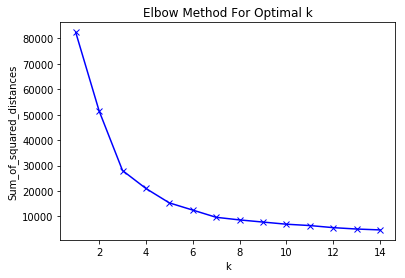

In [30]:
Sum_of_squared_distances = []
K = range(1,15)
for clust_num in K:
    km = KMeans(n_clusters = clust_num)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The most obvious elbow point is k = 3, however, checking the resulting groups shows more sensible clustering at k = 5, where each group is more succinct, with fewer outliers.

In [31]:
hours_matrix.groupby('k-means_labels')[['open', 'close']].mean()

open      close
k-means_labels                      
0                9.154773  18.510227
1               11.540182  23.806310
2                0.022727  23.980141
3                7.406463  22.921797
4               16.932990  25.335052

### Let's visualise the opening/closing time clusters that have been produced by k-means

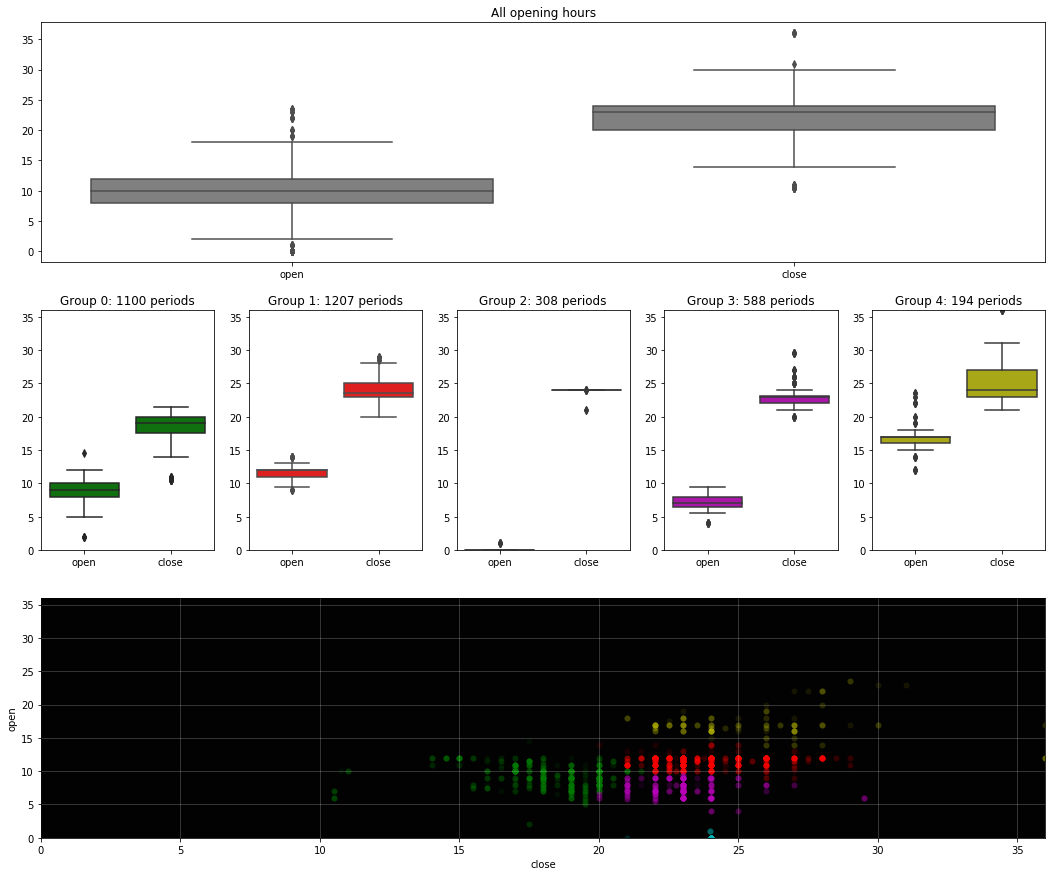

In [39]:
colours = ['g', 'r', 'c', 'm', 'y']

fig = plt.figure(figsize = (18, 15))
ax1 = fig.add_subplot(3, 1, 1)
ax3 = fig.add_subplot(3, 1, 3)

sns.boxplot(data = hours_matrix[['open','close']],
            ax = ax1,
           color = 'grey')

ax1.set_title("All opening hours")

for group, colour in zip(range(k), colours):
    
    subplot = fig.add_subplot(3, k, group + k +1)
    
    sns.boxplot(data = hours_matrix[hours_matrix['k-means_labels'] == group][['open','close']],
                ax = subplot,
               color = colour)
    
    subplot.set_ylim(0, X.max())
    group_count = hours_matrix[hours_matrix['k-means_labels'] == group].count()[0]
    title = "Group " + str(group) + ": " + str(group_count) + " periods"
    subplot.set_title(title)
    
    

    
    sns.scatterplot(data = hours_matrix[hours_matrix['k-means_labels'] == group][['open','close']],
                    x = 'close',
                    y = 'open',
                    linewidth = 0,
                    alpha = 0.1,
                    color = colour,
                    ax = ax3)
    
ax3.set_xlim(0, hours_matrix[['open','close']].max().max())
ax3.set_ylim(0, hours_matrix[['open','close']].max().max())
ax3.set_facecolor('#020202')
ax3.grid(color = '1', linestyle='-', linewidth = 1, alpha = 0.2)


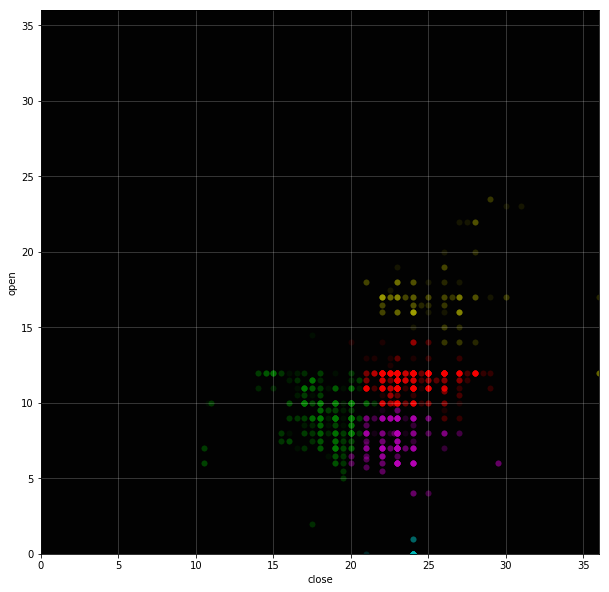

In [45]:
colours = ['g', 'r', 'c', 'm', 'y']

fig = plt.figure(figsize = (10, 10))
#ax1 = fig.add_subplot(3, 1, 1)
ax3 = fig.add_subplot(1, 1, 1)

sns.boxplot(data = hours_matrix[['open','close']],
            ax = ax1,
           color = 'grey')

ax1.set_title("All opening hours")

for group, colour in zip(range(k), colours):
    
  #  subplot = fig.add_subplot(3, k, group + k +1)
    
   # sns.boxplot(data = hours_matrix[hours_matrix['k-means_labels'] == group][['open','close']],
  #              ax = subplot,
   #            color = colour)
    
    #subplot.set_ylim(0, X.max())
    #group_count = hours_matrix[hours_matrix['k-means_labels'] == group].count()[0]
    #title = "Group " + str(group) + ": " + str(group_count) + " periods"
    #subplot.set_title(title)
    
    

    
    sns.scatterplot(data = hours_matrix[hours_matrix['k-means_labels'] == group][['open','close']],
                    x = 'close',
                    y = 'open',
                    linewidth = 0,
                    alpha = 0.1,
                    color = colour,
                    ax = ax3)
    
ax3.set_xlim(0, hours_matrix[['open','close']].max().max())
ax3.set_ylim(0, hours_matrix[['open','close']].max().max())
ax3.set_facecolor('#020202')
ax3.grid(color = '1', linestyle='-', linewidth = 1, alpha = 0.2)

## Try DBSCAN to see if better clusters might be made

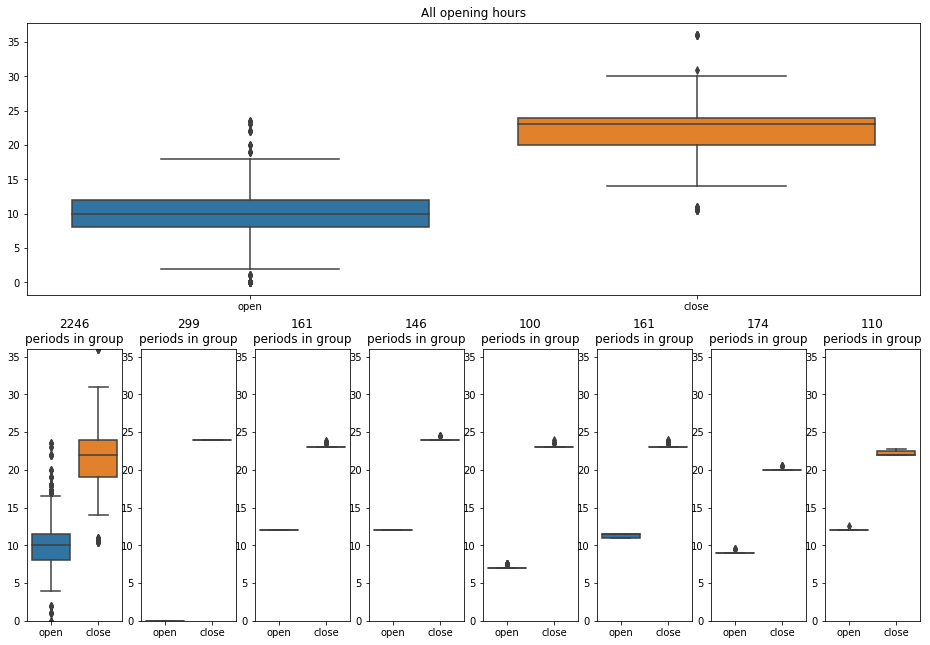

In [33]:
from sklearn.cluster import DBSCAN 

epsilon = 0.5
minimumSamples = 100

db = DBSCAN(eps = epsilon,
            min_samples = minimumSamples).fit(X)

hours_matrix['DBSCAN_labels'] = db.labels_ 

fig = plt.figure(figsize = (16, 11))
ax1 = fig.add_subplot(2, 1, 1)

sns.boxplot(data = hours_matrix[['open','close']],
            ax = ax1)
ax1.set_title("All opening hours")

DBSCAN_groups = hours_matrix['DBSCAN_labels'].value_counts().index
for group in DBSCAN_groups:
    subplot = fig.add_subplot(2, len(DBSCAN_groups), group + len(DBSCAN_groups) + 2)
    sns.boxplot(data = hours_matrix[hours_matrix['DBSCAN_labels'] == group][['open','close']],
                ax = subplot)
    subplot.set_ylim(0, X.max())
    group_count = hours_matrix[hours_matrix['DBSCAN_labels'] == group].count()[0]
    title = str(group_count) + "\nperiods in group"
    subplot.set_title(title)


DBSCAN's clusters are mostly very succinct, but with a major _outliers_ group, which tends to dominate regardless of different epsilon and min_sample parameters. The clustering performed by k-means is more intuitively sensible for opening times.

## Visualise the clusters of opening hours on a map

We can use the clustered opening times to learn a little more about the types of venue in those clusters, and view them on the map.

In [34]:
for x in np.sort(hours_matrix['k-means_labels'].unique()):
    opened = round(hours_matrix[hours_matrix['k-means_labels'] == x]['open'].mean())
    closed = round(hours_matrix[hours_matrix['k-means_labels'] == x]['close'].mean())
    common_ven = hours_matrix[hours_matrix['k-means_labels'] == x]['categories_simplified'].value_counts().index[0]
    print("==================================")
    print("Group {} typical characteristics\n".format(x + 1))
    print("Opening time: {}:00".format(opened))
    print("Closing time: {}:00".format(closed))
    print("Most common venue category: {}".format(common_ven))
    print('\n')
    
hours_clusters_map = folium.Map(location=[area_centre[0], area_centre[1]], zoom_start = 15) # generate map centred on the mean lat/long of our selection

for group, colour in zip(range(k), folium_colours):
    data = hours_matrix[(hours_matrix['k-means_labels'] == group) & (hours_matrix['Day'] == 'Friday')]
    for lat, lng, label in zip(data['location.lat'], data['location.lng'], data['k-means_labels']):
            folium.features.CircleMarker(
                                        [lat, lng],
                                        radius = 5,
                                        color = colour,
                                        fill = True,
                                        popup = str(label),
                                        fill_color = colour,
                                        fill_opacity = 0.6,
                                        linewidth = 0.1,
                                        ).add_to(hours_clusters_map)

# display map
hours_clusters_map

Group 1 typical characteristics

Opening time: 9:00
Closing time: 19:00
Most common venue category: Coffee Shop


Group 2 typical characteristics

Opening time: 12:00
Closing time: 24:00
Most common venue category: Pub


Group 3 typical characteristics

Opening time: 0:00
Closing time: 24:00
Most common venue category: Hotel


Group 4 typical characteristics

Opening time: 7:00
Closing time: 23:00
Most common venue category: Grocery Store


Group 5 typical characteristics

Opening time: 17:00
Closing time: 25:00
Most common venue category: Gay Bar




## Finally, build a suggester
The function below accepts opening and closing time as integers for both arguments, and will suggest areas where you can expect high foot traffic.

In [35]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="daveCK")

#Let's build something that suggests some addresses to look at based on opening hours
def suggester(opening, closing):
    # could return addresses of clustered areas
    # typical opening hours
    # types of venue
    print('===========================================================================')
    print('Suitable areas around {}, {} for a venue opening between {}:00 and {}:00'.format(area_centre[0],
                                                                                      area_centre[1],
                                                                                      opening,
                                                                                      closing))
    print('===========================================================================\n')
    request_hours = np.array([[opening, closing]])
    request_cluster = int(k_means.predict(request_hours))
    
    typical_open = int(k_means.cluster_centers_[request_cluster].round()[0])
    typical_close = int(k_means.cluster_centers_[request_cluster].round()[1])
    print("Locally the most similar common opening times are from {}:00 to {}:00".format(typical_open, typical_close))
    print("(Times past 24:00 represent venues staying open past midnight and closing the following day.)\n")
    print("Venues sharing these opening times are grouped around the areas below.")
    print("These areas should promise the greatest foot traffic during the selected opening hours.")
    
    data = hours_matrix.loc[hours_matrix['k-means_labels'] == request_cluster, :].copy()

    epsilon = 0.001
    minimumSamples = 10

    db = DBSCAN(eps = epsilon,
                min_samples = minimumSamples).fit(data[['location.lat', 'location.lng']].to_numpy())

    data['DBSCAN_labels'] = db.labels_ 

    DBSCAN_groups = data['DBSCAN_labels'].value_counts().index
    
    temp_map = folium.Map(location=[area_centre[0], area_centre[1]], zoom_start = 15) # generate map centred on the mean lat/long of our selection

    for group, colour, letter in zip(DBSCAN_groups[DBSCAN_groups != -1][1:6], folium_colours, ['A', 'B', 'C', 'D', 'E']):
        sub_data = data[data['DBSCAN_labels'] == group]
        if group == -1:
            colour = 'grey'
        for lat, lng, label in zip(sub_data['location.lat'], sub_data['location.lng'], sub_data['categories_simplified']):
                folium.features.CircleMarker(
                                            [lat, lng],
                                            radius = 5,
                                            color = colour,
                                            fill = True,
                                            popup = letter,
                                            fill_color = colour,
                                            fill_opacity = 0.6,
                                            linewidth = 0.1,
                                            ).add_to(temp_map)

#    for group, letter in zip(DBSCAN_groups[DBSCAN_groups != -1][1:6], ['A', 'B', 'C', 'D', 'E']):

        lat_avg = data[data['DBSCAN_labels'] == group]['location.lat'].mean()
        lng_avg = data[data['DBSCAN_labels'] == group]['location.lng'].mean()
        print('\n')
        print("Group {} is centred around {}, {}".format(letter, lat_avg, lng_avg))
        print("-----------------------------------------------------------------")
        
        coords = "{}, {}".format(lat_avg, lng_avg)
        location = geolocator.reverse(coords)
        print("Suggested address to investigate:", location.address)

        common_cat = data[data['DBSCAN_labels'] == group]['categories_simplified'].mode()[0]
        print("Venues in this area with similar opening times are mostly of type '{}'".format(common_cat))

    # display map
    return temp_map

### Run the suggester

In [36]:
suggester(12, 26)

Suitable areas around 53.480472, -2.246467 for a venue opening between 12:00 and 26:00

Locally the most similar common opening times are from 11:00 to 24:00
(Times past 24:00 represent venues staying open past midnight and closing the following day.)

Venues sharing these opening times are grouped around the areas below.
These areas should promise the greatest foot traffic during the selected opening hours.


Group A is centred around 53.48265498310224, -2.2365076214437387
-----------------------------------------------------------------
Suggested address to investigate: Big Horn, Tib Street, Northern Quarter, City Centre, Manchester, Greater Manchester, North West England, England, M4 1PQ, UK
Venues in this area with similar opening times are mostly of type 'Bar'


Group B is centred around 53.47651041065563, -2.2372740616941558
-----------------------------------------------------------------
Suggested address to investigate: Lock87, 3, Brazil Street, Gay Village, City Centre, Manch

This concludes the analysis. We have acquired data on venues inside the area of interest, and identified locations within that area that are suitable for a new venue given that venue's intended opening hours. At the same time the analysis provides local insight into how well aligned the intended opening hours are with local norms, and what type of venue would typically use those opening hours in this area.

## Results and Discussion <a name="results"></a>

Given a centre for the area of interest we were able to obtain extensive data on existing venues in the area, and infer suitable locations for a venue purely on the basis of opening hours.

Our analysis showed that the area of interest contained 5 typical opening hour groups, and that particular categories of venue belong in each. It also showed that those venues tended to cluster together physically, allowing us to identify locations that would be suitable for a similar venue, and avoid researching areas where foot traffic during the opening hours would be low.

The script is arranged in such a way that a new area of interest could be selected for analysis, and any combination of opening hours tested for suitable locations. The final result gives the addresses at the centre of each cluster, which would form the basis for further investigation by the stakeholders.

#### Group 1

Opening time: 0:00

Closing time: 24:00

Most common venue category: Hotel


==================================

#### Group 2

Opening time: 9:00

Closing time: 18:00

Most common venue category: Coffee Shop


==================================

#### Group 3

Opening time: 11:00

Closing time: 24:00

Most common venue category: Pub


==================================

#### Group 4

Opening time: 7:00

Closing time: 23:00

Most common venue category: Grocery Store


==================================

#### Group 5

Opening time: 17:00

Closing time: 25:00

Most common venue category: Gay Bar

# Conclusion <a name="conclusion"></a>
The goal was to provide meaningful insight into the movement of people around a city with which the stakeholder is not familiar, and in doing so suggest areas that may be optimal for a new venue. By clustering first the opening hours, and then the locations of the venues, we can provide clear examples of areas in the city that will be busy at the times specified, and visualise them on a map.

One limitation is that the method of data-retrieval is slow, and necessarily incurs significant redundancy during the initial load-in. Additionally, several categories were removed in order to reduce the number of API calls required. A better Foursquare account would reduce these problems significantly, and increase the degree of insight that the notebook can provide (eg. offices and bus stops were removed from the data, but are probably quite important to the inferal of foot traffic).

Finally, a stakeholder is able to use this notebook to guide their initial investigations into an unknown area, confident tha they have not overlooked local idiosyncrasies, and learn about the common types of venue.

